In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from src.LassoFixedN import LassoFixedN
from src.two_level_MC import get_two_level_estimates

np.random.seed(42)

# Input generator

In [2]:
d = 1000  # Input dimension.

def get_input(N):
    return np.random.randn(N,d)

# Family of models

Family of linear models with high input dimension d, and similar coefficients with random perturbations.

In [3]:
L = 3  # Number of models.
intercepts = np.zeros(L)
coefs = np.zeros((d,L))
for k in range(L):
    intercepts[k] = np.random.randn()*10
    coefs[:,k] = (np.random.rand(d) 
                  + np.random.rand()
                  * np.concatenate([np.array([1,2,5,10,20,50,100]), 1000*np.ones(d-7)]))
def models(k,xs):
    return np.matmul(xs, 1/coefs[:,k]) + intercepts[k]

True mean [ 4.96723936 -1.38255323  9.13646877]
True std [0.79952699 1.43483296 0.87061722]
True skewness [-0.00122752 -0.00104398 -0.00182155]


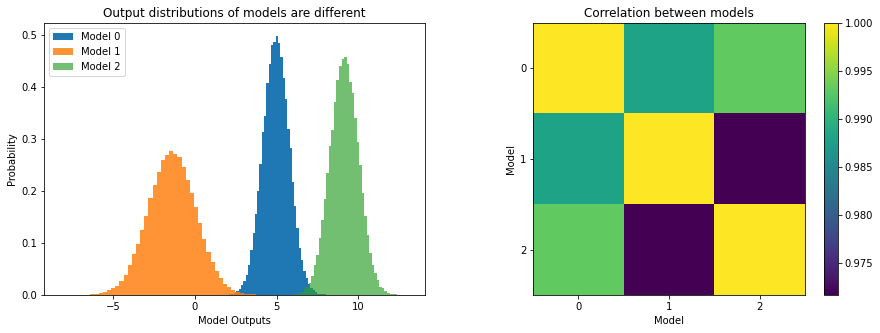

In [4]:
N_reference = 10**5  # Number of samples for reference solution.
xs = get_input(N_reference)
ys = np.zeros((N_reference, L))

true_moments = np.zeros((3,L))
for k in range(L):
    ys[:,k] = models(k,xs)
    true_moments[0,k] = ys[:,k].mean()
    true_moments[1,k] = ys[:,k].var(ddof=1)
    true_moments[2,k] = (N_reference / (N_reference-2) / (N_reference) 
                         * np.sum((ys[:,k] - true_moments[0,k])**3))

print("True mean", true_moments[0])
print("True std", np.sqrt(true_moments[1]))
print("True skewness", true_moments[2] / true_moments[1]**1.5)

corr_mat = np.corrcoef(ys, rowvar = False)

fig, axs = plt.subplots(1,2,figsize = (15,5))
axs = axs.reshape(-1)

for k in range(L):
    axs[0].hist(ys[:,k], bins = 50, alpha = 1 - 0.5*k/L,
                label = "Model " + str(k), density = True)
axs[0].set_xlabel("Model Outputs")
axs[0].set_ylabel("Probability")
axs[0].legend()
axs[0].set_title("Output distributions of models are different")

cmap = axs[1].imshow(corr_mat)
axs[1].set_xticks(np.arange(3))
axs[1].set_yticks(np.arange(3))
axs[1].set_xlabel("Model")
axs[1].set_ylabel("Model")
axs[1].set_title("Correlation between models")
plt.colorbar(cmap)
plt.show()

# MFMC

## Model 0: make training set and train a low-fidelity model

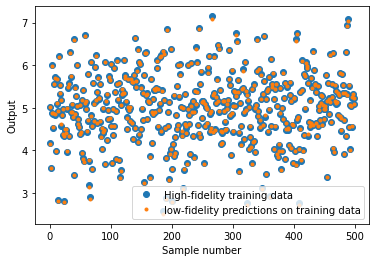

In [5]:
N = 500
xs = get_input(N)
ys = models(0, xs)

regressor = Pipeline([('scaler', StandardScaler()),
                      ('reg', LassoFixedN(Nfeat = 0.95,
                                          output_scaler = PowerTransformer()
                                         )),
                     ])
regressor.fit(xs, ys)
low_fi_model = regressor.predict
plt.plot(ys, 'o', label = "High-fidelity training data")
plt.plot(low_fi_model(xs), ".", label = "low-fidelity predictions on training data")
plt.xlabel("Sample number")
plt.ylabel("Output")
plt.legend()
plt.show()

## Other models: use MFMC

Fix M>>N, and increase N little by little. Compute moments with MFMC and simple MC to compare.

### Model 1

In [6]:
Nmax = 10**3
len_N = 20
Ns = np.logspace(1,np.log10(Nmax), len_N, dtype = int)
M = 10**5


# The high-fidelity model is executed only Nmax times.
xs = get_input(Nmax)
ys = models(1, xs)

# The low-fidelity model is executed Nmax + M times.
ys_low_fi = low_fi_model(xs)
zs = get_input(M)
ys_low_fi_M = low_fi_model(zs)

moments_MC = np.zeros((len_N, 3))
moments_MFMC = np.zeros((len_N, 3))

RMSEs_MC = np.zeros((len_N, 3))
RMSEs_MFMC = np.zeros((len_N, 3))
for i,N in enumerate(Ns):
    results = get_two_level_estimates(ys[:N], ys_low_fi[:N], ys_low_fi_M, 
                                      calculate_MSEs = True, 
                                      adjust_alpha = True)  # If true α-MFMC is used, if false MFMC
    print()
    print("Alpha = ", results['alpha'])  # Print alpha used in the alpha-MFMC estimator.
    moments_MC[i] = results['moments MC'][:3]  # Mean, variance, skewness, kurtosis
    moments_MFMC[i] = results['moments MFMC'][:3]
    
    # The MSE can be split into a part that converges as 1/M, and a part that converges as 1/N
    # For example, the MSE of the mean estimation cna be split as
    print("The M samples are responsible for the variance {:.2e}".format(results['Vars surr'][0]))
    print("The N samples are responsible for the variance {:.2e}".format(results['Vars comb'][0]))
    # Generally "Vars comb" should be bigger because N<<M
    
    RMSEs_MC[i] = np.sqrt(results['MSEs MC'][:3])
    RMSEs_MFMC[i] = np.sqrt(results['MSEs MFMC'][:3])


Alpha =  1.7489988452020981
The M samples are responsible for the variance 1.93e-05
The N samples are responsible for the variance 5.11e-03

Alpha =  1.771914344254037
The M samples are responsible for the variance 1.99e-05
The N samples are responsible for the variance 3.59e-03

Alpha =  1.713161867830305
The M samples are responsible for the variance 1.86e-05
The N samples are responsible for the variance 3.81e-03

Alpha =  1.7151421627234809
The M samples are responsible for the variance 1.86e-05
The N samples are responsible for the variance 2.66e-03

Alpha =  1.7073416616397803
The M samples are responsible for the variance 1.84e-05
The N samples are responsible for the variance 1.99e-03

Alpha =  1.7116638095066625
The M samples are responsible for the variance 1.85e-05
The N samples are responsible for the variance 1.65e-03

Alpha =  1.701459676237348
The M samples are responsible for the variance 1.83e-05
The N samples are responsible for the variance 1.26e-03

Alpha =  1.6996

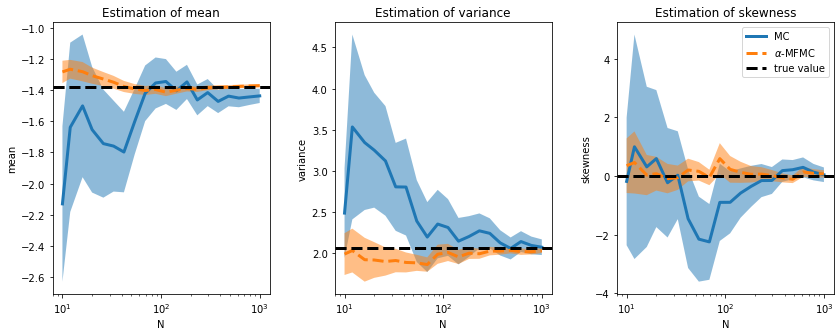

In [7]:
fig, axs = plt.subplots(1, 3, figsize = (14,5))
axs = axs.reshape(-1)

for i,moment in enumerate(['mean', 'variance', 'skewness']):
    axs[i].plot(Ns, moments_MC[:,i], label = 'MC', lw = 3)
    axs[i].fill_between(Ns, moments_MC[:,i] - RMSEs_MC[:,i],  
                        moments_MC[:,i] + RMSEs_MC[:,i], alpha = 0.5)
    axs[i].plot(Ns, moments_MFMC[:,i], label = r'$\alpha$-MFMC', lw = 3, ls = '--')
    axs[i].fill_between(Ns, moments_MFMC[:,i] - RMSEs_MFMC[:,i], 
                        moments_MFMC[:,i] + RMSEs_MFMC[:,i], alpha = 0.5)
    
    axs[i].axhline(true_moments[i,1], ls = '--', color = 'k', lw = 3, label = "true value")
    axs[i].set_title('Estimation of ' + moment)
    axs[i].set_xlabel('N')
    axs[i].set_ylabel(moment)
    axs[i].set_xscale('log')
    
axs[-1].legend()
fig.subplots_adjust(wspace = .3)
plt.show()
    

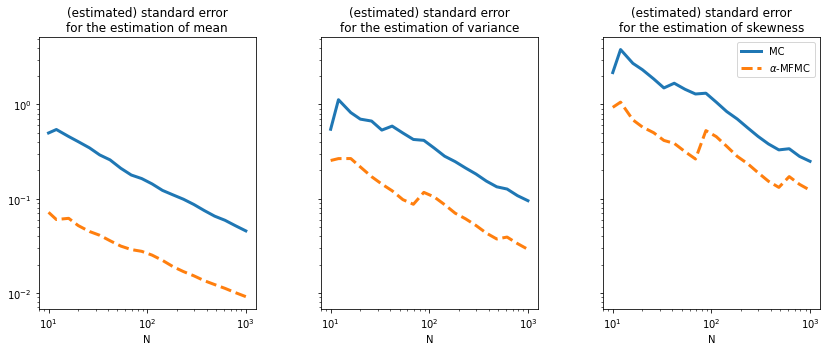

In [8]:
fig, axs = plt.subplots(1, 3, figsize = (14,5), sharey = True)
axs = axs.reshape(-1)

for i,moment in enumerate(['mean', 'variance', 'skewness']):
    axs[i].plot(Ns, RMSEs_MC[:,i], label = 'MC', lw = 3)
    axs[i].plot(Ns, RMSEs_MFMC[:,i], label = r'$\alpha$-MFMC', lw = 3, ls = '--')
    axs[i].set_title('(estimated) standard error\nfor the estimation of ' + moment)
    axs[i].set_xlabel('N')
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    
axs[-1].legend()
fig.subplots_adjust(wspace = .3)
plt.show()
    

### Model 2

In [9]:
Nmax = 10**3
len_N = 20
Ns = np.logspace(1,np.log10(Nmax), len_N, dtype = int)
M = 10**5


# The high-fidelity model is executed only Nmax times.
xs = get_input(Nmax)
ys = models(2, xs)

# The low-fidelity model is executed Nmax + M times.
ys_low_fi = low_fi_model(xs)
zs = get_input(M)
ys_low_fi_M = low_fi_model(zs)

moments_MC = np.zeros((len_N, 3))
moments_MFMC = np.zeros((len_N, 3))

RMSEs_MC = np.zeros((len_N, 3))
RMSEs_MFMC = np.zeros((len_N, 3))
for i,N in enumerate(Ns):
    results = get_two_level_estimates(ys[:N], ys_low_fi[:N], ys_low_fi_M, 
                                      calculate_MSEs = True, 
                                      adjust_alpha = True)
    print()
    print("Alpha = ", results['alpha'])  # Print alpha used in the alpha-MFMC estimator.
    moments_MC[i] = results['moments MC'][:3]  # Mean, variance, skewness, kurtosis
    moments_MFMC[i] = results['moments MFMC'][:3]
    
    # The MSE can be split into a part that converges as 1/M, and a part that converges as 1/N
    # For example, the MSE of the mean estimation cna be split as
    print("The M samples are responsible for the variance {:.2e}".format(results['Vars surr'][0]))
    print("The N samples are responsible for the variance {:.2e}".format(results['Vars comb'][0]))
    # Generally "Vars comb" should be bigger because N<<M
    
    RMSEs_MC[i] = np.sqrt(results['MSEs MC'][:3])
    RMSEs_MFMC[i] = np.sqrt(results['MSEs MFMC'][:3])


Alpha =  1.0862092994234824
The M samples are responsible for the variance 7.45e-06
The N samples are responsible for the variance 1.43e-03

Alpha =  1.063991927621488
The M samples are responsible for the variance 7.15e-06
The N samples are responsible for the variance 1.15e-03

Alpha =  1.0517324848514402
The M samples are responsible for the variance 6.99e-06
The N samples are responsible for the variance 7.47e-04

Alpha =  1.0513259672313375
The M samples are responsible for the variance 6.98e-06
The N samples are responsible for the variance 5.04e-04

Alpha =  1.0480634515487621
The M samples are responsible for the variance 6.94e-06
The N samples are responsible for the variance 3.66e-04

Alpha =  1.060129792362693
The M samples are responsible for the variance 7.10e-06
The N samples are responsible for the variance 2.81e-04

Alpha =  1.0511342937460701
The M samples are responsible for the variance 6.98e-06
The N samples are responsible for the variance 2.05e-04

Alpha =  1.073

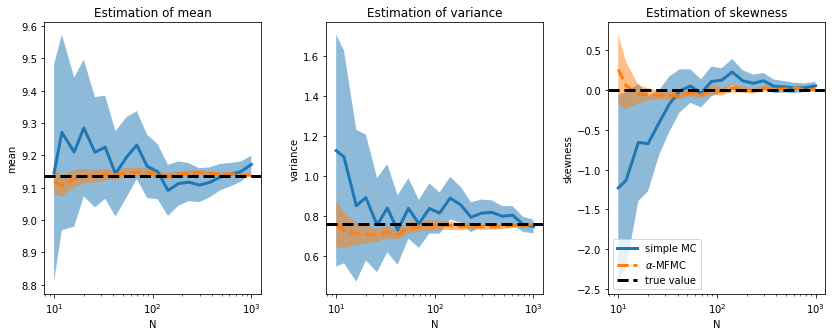

In [10]:
fig, axs = plt.subplots(1, 3, figsize = (14,5))
axs = axs.reshape(-1)

for i,moment in enumerate(['mean', 'variance', 'skewness']):
    axs[i].plot(Ns, moments_MC[:,i], label = 'simple MC', lw = 3)
    axs[i].fill_between(Ns, moments_MC[:,i] - RMSEs_MC[:,i],  
                        moments_MC[:,i] + RMSEs_MC[:,i], alpha = 0.5)
    axs[i].plot(Ns, moments_MFMC[:,i], label = r'$\alpha$-MFMC', lw = 3, ls = '--')
    axs[i].fill_between(Ns, moments_MFMC[:,i] - RMSEs_MFMC[:,i], 
                        moments_MFMC[:,i] + RMSEs_MFMC[:,i], alpha = 0.5)
    
    axs[i].axhline(true_moments[i,2], ls = '--', color = 'k', lw = 3, label = "true value")
    axs[i].set_title('Estimation of ' + moment)
    axs[i].set_xlabel('N')
    axs[i].set_ylabel(moment)
    axs[i].set_xscale('log')
    
axs[-1].legend()
fig.subplots_adjust(wspace = .3)
plt.show()
    